## **COST OF MEDICAL INSURANCE PREDICTION & EXPLORATORY DATA ANALYSIS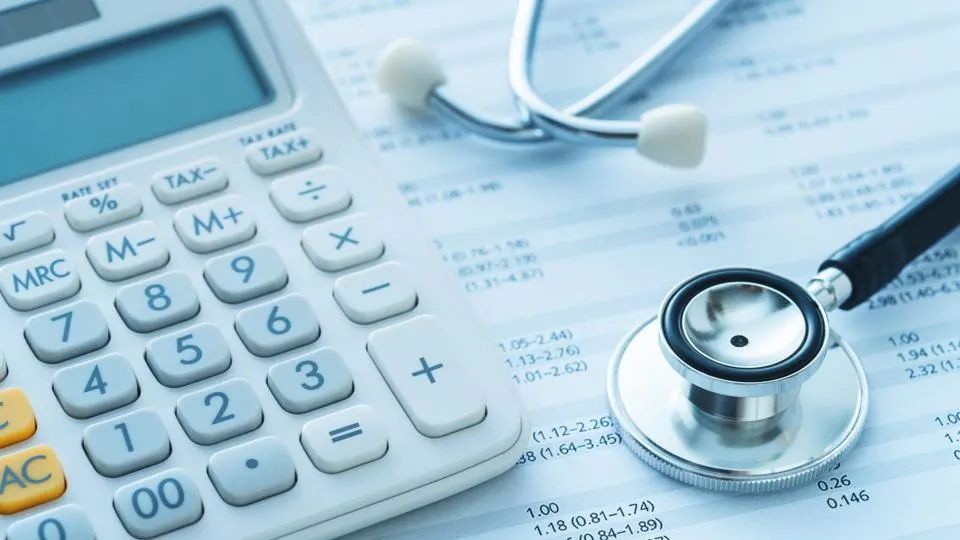**



**CONTEXT:**

Health insurance is an essential safeguard against unexpected and unaffordable medical expenses, but policies can be pricey. You can spend thousands a year on premiums, and even with health insurance, you may face copayments, coinsurance and a deductible. The costs can add up, and could even be influenced by lots factors like the patient's location, lifestyle, etc.

In this project, we shall be looking at the various relationships between these factors influencing the cost of hospital insurance. According to our dataset, the following are the factors which have a certain level of influence on the cost of medical insurance:

* age: age of primary beneficiary

* sex: insurance contractor gender, female, male

* bmi: this implies the Body Mass Index. It provides an understanding of body in relative to height. It is calculated as the objective index of body weight (kg / m ^ 2) using the ratio of height to weight. 18.5kg/m^2 to 24.9kg/m^2 is underweight, 25kg/m^2 to 29.9kg/m^2 is normal, >= 30kg/m^2 is within the obese range.

* children: Number of children covered by health insurance / Number of dependents

* smoker: Smoking status

* region: the beneficiary's residential area in the US, northeast, southeast, southwest, northwest.


**AIM:**

This project aims to predict the cost of hospital insurance and analyse the various factors that influence the cost of insurance. The prediction will be done using various regression models in order to determine which is best for it.

**SOURCE OF THE DATASET**

The dataset was sourced from Kaggle.

---



**Importing The Necessary Libraries:**

---



In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import norm, boxcox
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats.mstats import normaltest
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso  # noqa F401
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold



---



**Loading, Understanding, Cleaning, And Wrangling of Our Data:**

---



In [2]:
#let's read our dataset into a DataFrame and get the view of the first 10 rows
insur_df = pd.read_csv('/content/drive/MyDrive/Datasets/insurance.csv')
insur_df.head(10)

,index,age,sex,bmi,children,smoker,region,charges
0,0,19,female,27.900,0,yes,southwest,16884.92400
1,1,18,male,33.770,1,no,southeast,1725.55230
2,2,28,male,33.000,3,no,southeast,4449.46200
3,3,33,male,22.705,0,no,northwest,21984.47061
4,4,32,male,28.880,0,no,northwest,3866.85520
5,5,31,female,25.740,0,no,southeast,3756.62160
6,6,46,female,33.440,1,no,southeast,8240.58960
7,7,37,female,27.740,3,no,northwest,7281.50560
8,8,37,male,29.830,2,no,northeast,6406.41070
9,9,60,female,25.840,0,no,northwest,28923.13692


In [3]:
#let's get the shape of our DataFrame
print(f'The Shape of Our DataFrame is:{insur_df.shape}')

The Shape of Our DataFrame is:(1338, 8)


In [4]:
#let's get the general info about the DataFrame
insur_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   index     1338 non-null   int64  
 1   age       1338 non-null   int64  
 2   sex       1338 non-null   object 
 3   bmi       1338 non-null   float64
 4   children  1338 non-null   int64  
 5   smoker    1338 non-null   object 
 6   region    1338 non-null   object 
 7   charges   1338 non-null   float64
dtypes: float64(2), int64(3), object(3)
memory usage: 83.8+ KB


Comments:
*   Looks like there are no missing values in our data. We'll comfirm that
    as we go on
*   We'll have to drop the index column because it will mostly be
    useless to our model.



In [5]:
#let's drop the index column
insur_df.drop(columns={'index'}, inplace=True)
insur_df.columns

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges'], dtype='object')

In [6]:
#let's rename the children column to number of children for clarity purpose
insur_df.rename(columns={'children':'number_of_children'}, inplace=True)

***Descriptive Statistics of Our Numerical Columns:***

In [7]:
#let's get the descriptive statistics of the numerical columns
stats_df = round(insur_df.describe(),2)
#let's add new field that will contain the range of each numerical columns
stats_df.loc['range'] = round(stats_df.loc['max'] - stats_df.loc['min'],2)
#let's specify the fields of interest to be displayed
spec_field = ['mean', 'std', 'min', '25%', '50%', '75%','max', 'range']
stats_df = stats_df.loc[spec_field]
#let's rename the '50%' field to median field
stats_df.rename({'50%': 'median'}, inplace=True)
stats_df



,age,bmi,number_of_children,charges
mean,39.21,30.66,1.09,13270.42
std,14.05,6.10,1.21,12110.01
min,18.00,15.96,0.00,1121.87
25%,27.00,26.30,0.00,4740.29
median,39.00,30.40,1.00,9382.03
75%,51.00,34.69,2.00,16639.91
max,64.00,53.13,5.00,63770.43
range,46.00,37.17,5.00,62648.56


***Descriptive Statistics of Our Categorical Columns:***

In [8]:
insur_df.describe(exclude=['int64', 'float64'])

,sex,smoker,region
count,1338,1338,1338
unique,2,2,4
top,male,no,southeast
freq,676,1064,364


In [9]:
#let's check for duplicates
insur_df.duplicated().sum()

1

comment:
*   We have one duplicated row, hence, it's safe to just drop the row



In [10]:
#drop duplicate
insur_df.drop_duplicates(inplace=True)
insur_df.duplicated().sum()

0

In [11]:
#let's check for missing values
insur_df.isna().sum()

age                   0
sex                   0
bmi                   0
number_of_children    0
smoker                0
region                0
charges               0
dtype: int64

*comment:*

*   There is no missing value in our data





---



**EXPLPORATORY DATA ANALYSIS**

---



>>**Numerical Columns:**

In [12]:
insur_df.select_dtypes('number').columns

Index(['age', 'bmi', 'number_of_children', 'charges'], dtype='object')

Comment:

Basically, we have four columns, viz; age, bmi, number_of_children, and charges(target column). We shall be exploring and analysing each of them below.

*let's write a function that can visualize the distribution of our numerical columns and show the presence of outliers if any using different plots*

In [13]:
def plotting_2_charts(col):
  #import
  import seaborn as sns
  import matplotlib.pyplot as plt
  import matplotlib.gridspec as gridspec
  import matplotlib.style as style
  style.use('fivethirtyeight')
  from matplotlib.layout_engine import ConstrainedLayoutEngine

  #creating a customized chart, fitting it into the layout, and sizing it
  fig = plt.figure(constrained_layout=True, figsize=(10,6))
  #creating a grid of 2 rows and 2 columns
  grid = gridspec.GridSpec(ncols=2, nrows=2, figure=fig)

  #customizing the hiatogram grid
  ax1 = fig.add_subplot(grid[0, :1])
  #set title
  ax1.set_title('Histogram')
  #plot the histogram
  sns.distplot(col, norm_hist=True, ax=ax1)

  #customizing the QQ_plot
  ax2 = fig.add_subplot(grid[:, 1])
  #set the title
  ax2.set_title('Box_plot')
  #plot the QQ_plot
  sns.boxplot(col, orient='v', ax=ax2)


  return plotting_2_charts;


***Age:***

Let's visualize and analyse the age column by calling our function on it.

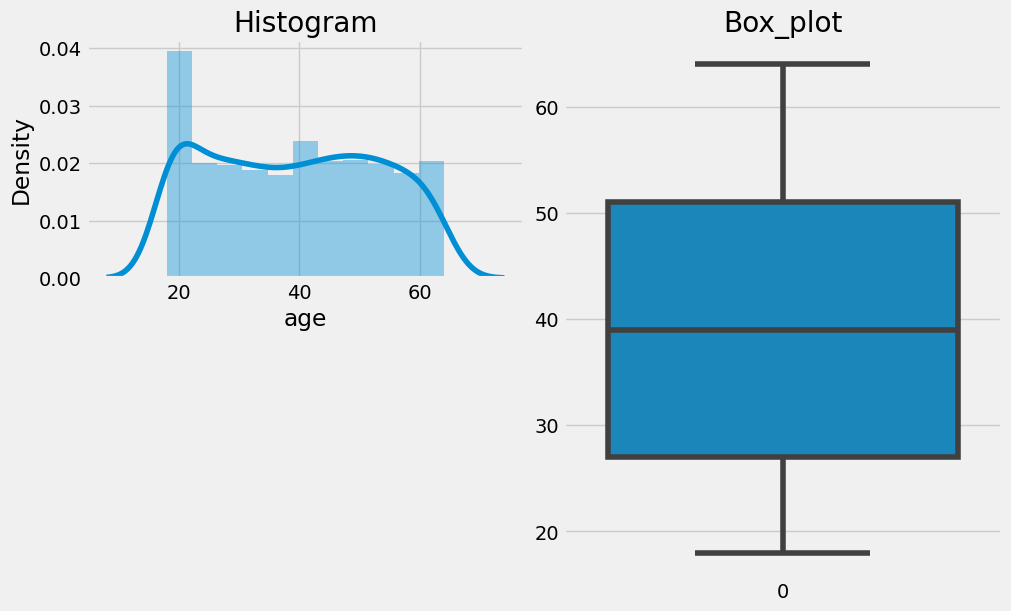

In [14]:
plotting_2_charts(insur_df.age);

Observations:

*   Most people are within the age of 18 to 23 years
*   The age column is not normally distributed
*   There are no outliers in the age column



***BMI(Body Mass Index):***

Let's visualize and analyse the bmi column by calling our function on it

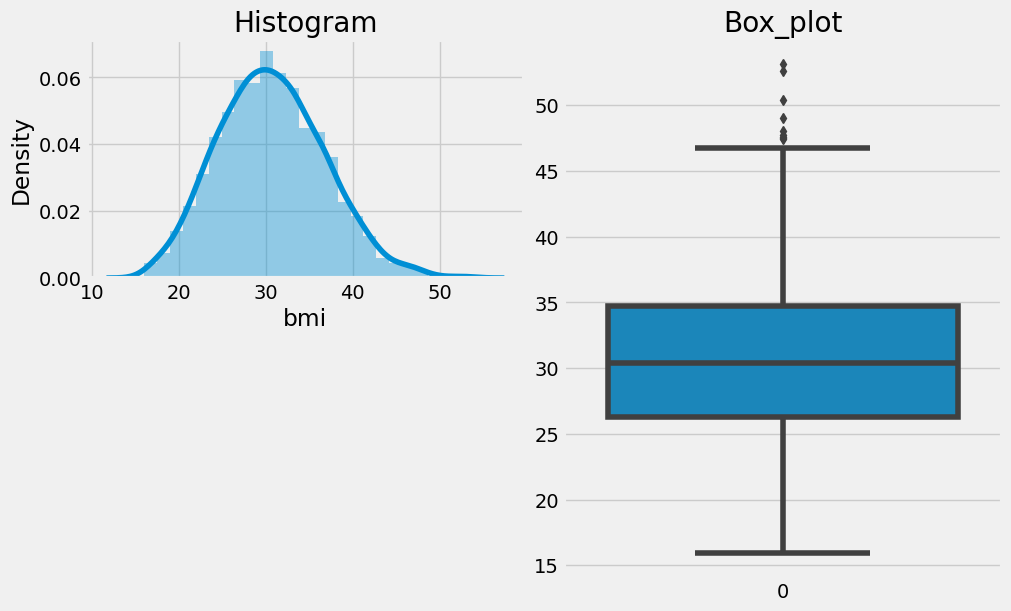

In [15]:
plotting_2_charts(insur_df.bmi);

Observations:

*   There is more number of people who are overweight; that is with a BMI of 30kg/m^2 and above.
*   The BMI column is normally distributed.
*   There are outliers in the BMI column



***Number_of_children:***

Let's visualize and analyse the number_of_children column

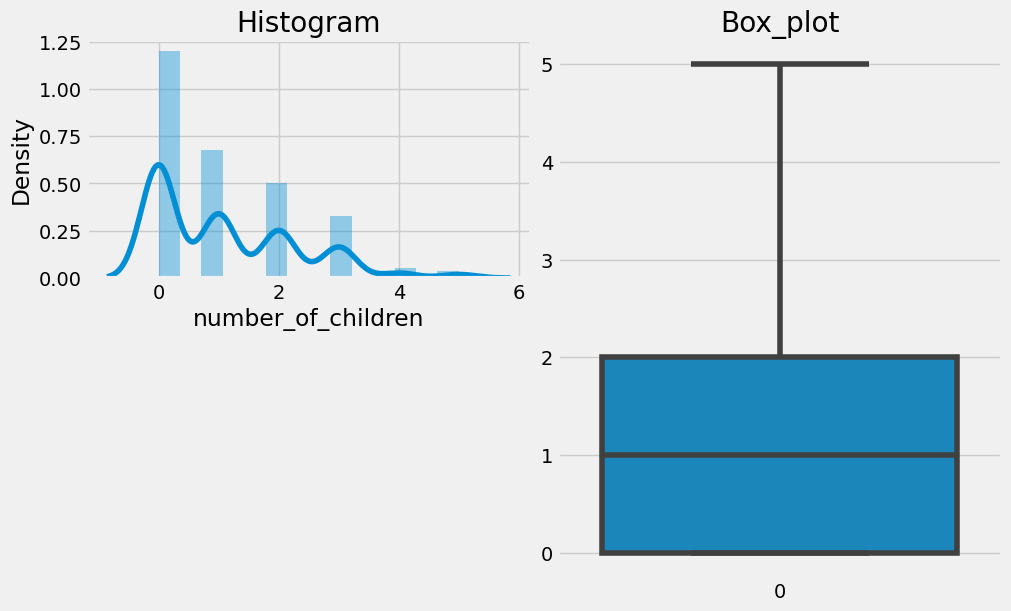

In [16]:
plotting_2_charts(insur_df.number_of_children);

Observations:

*   There is more number of people with no children
*   The number_of_children column has no outliers



***Charges:***

Let's edit our initial function so that it is able to plot 3 graphs as a means of analysing the distribution and possible transformative approaches if need be, of our target column which is the charges column:

In [17]:

def plotting_3_charts(col):
  #import
  import seaborn as sns
  import matplotlib.pyplot as plt
  import matplotlib.gridspec as gridspec
  import matplotlib.style as style
  style.use('fivethirtyeight')
  from matplotlib.layout_engine import ConstrainedLayoutEngine
  from scipy import stats

  #creating a customized chart, fitting it into the layout, and sizing it
  fig = plt.figure(constrained_layout=True, figsize=(12,8))
  #creating a grid of 3 rows and 3 columns
  grid = gridspec.GridSpec(ncols=3, nrows=3, figure=fig)

  #customizing the hiatogram grid
  ax1 = fig.add_subplot(grid[0, :2])
  #set title
  ax1.set_title('Histogram')
  #plot the histogram
  sns.distplot(col, norm_hist=True, ax=ax1)

  #customizing the QQ_plot
  ax2 = fig.add_subplot(grid[1, :2])
  #set the title
  ax2.set_title('QQ_plot')
  #plot the QQ_plot
  stats.probplot(col, plot=ax2)

  #customizing boxplot
  ax3 = fig.add_subplot(grid[:, 2])
  #set the title
  ax3.set_title('Box_plot')
  #plot the box_plot
  sns.boxplot(col, orient='v', ax=ax3)


  return plotting_3_charts;





*let's now call on the fuction, plotting_3_charts, to visualize the distribution of the charges column:*

<function __main__.plotting_3_charts(col)>

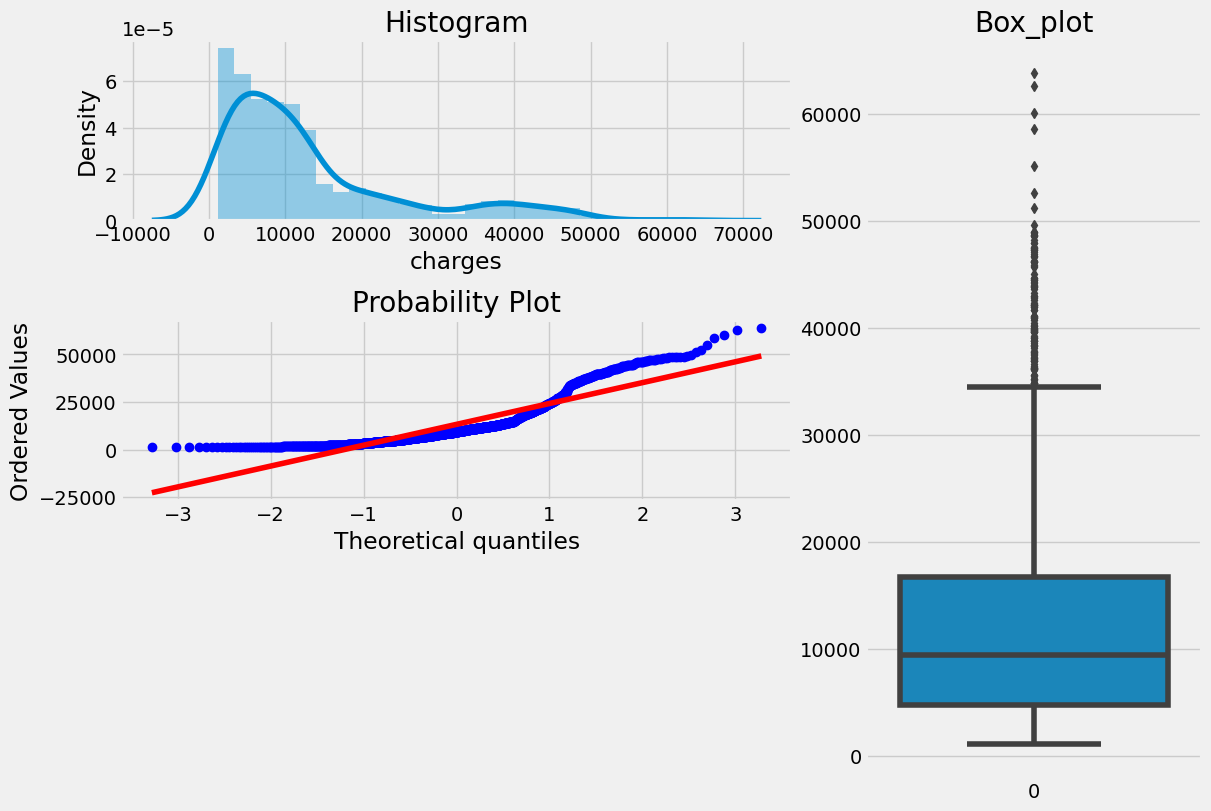

In [19]:

plotting_3_charts(insur_df['charges'])

In [20]:
#let's employ normal test to further check for the skewness. If the p-value is greater than 0.5 then it is skewed
normaltest(insur_df.charges.values)

NormaltestResult(statistic=336.4416065386955, pvalue=8.762608303862979e-74)

In [21]:
#let's calculate the level of the skewness.
print(f'Skewness: {insur_df.charges.skew()}')

Skewness: 1.5153909108403483


**comments:**

*  *from our visualization and calculations, our target column, charges, is highly skewed towards the right direction, hence, we will need to transform it.*

*  *Also, there are presence of outliers in the charges column, we may need to fix that later on.*



***Log Transformation:***

<function __main__.plotting_3_charts(col)>

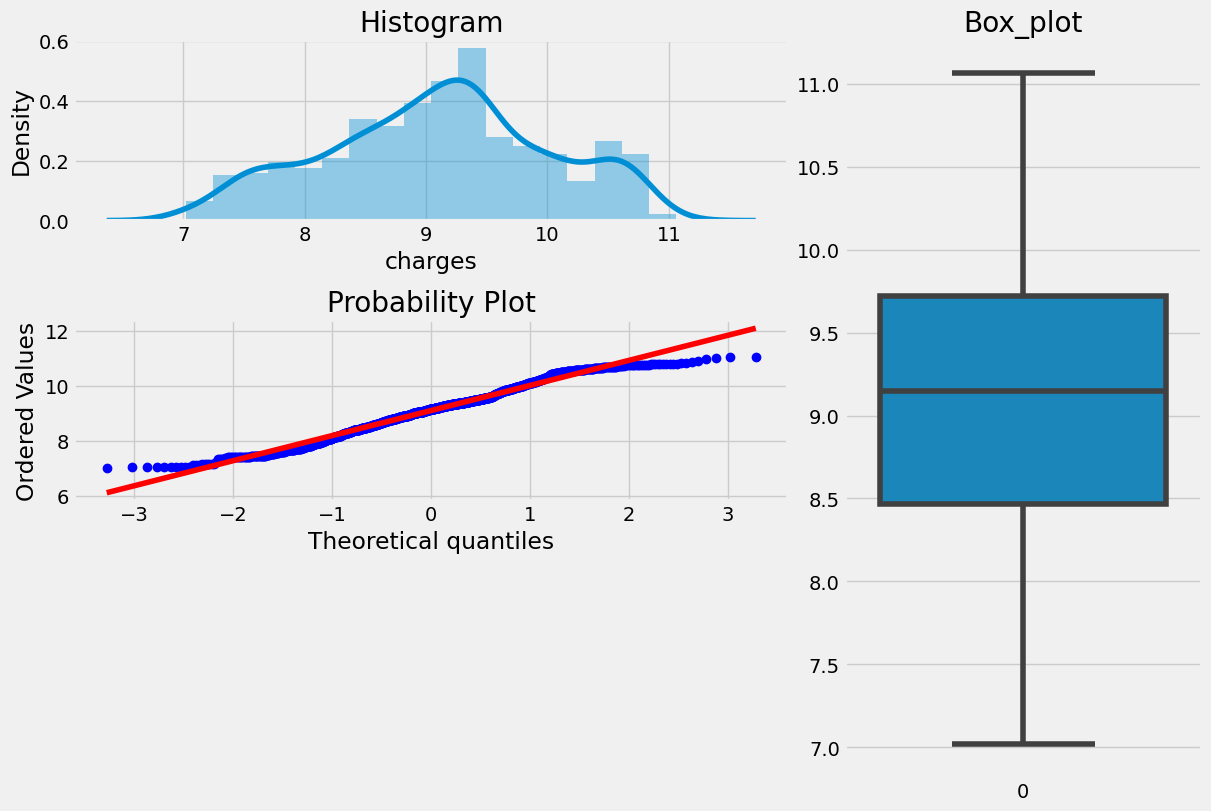

In [22]:
#let's transform the charges column using log transformation
log_target = np.log(insur_df.charges)
#visualize the transformation with our function
plotting_3_charts(log_target)

In [23]:
#let's employ normal test to further check for the skewness. If the p-value is greater than 0.5 then it is skewed
normaltest(log_target.values)

NormaltestResult(statistic=52.147628145443655, pvalue=4.745548606594116e-12)

In [24]:
#let's the level of skewness
print(f'Skewness: {log_target.skew()}')

Skewness: -0.08983863481292871


***boxcox transformation:***

<function __main__.plotting_3_charts(col)>

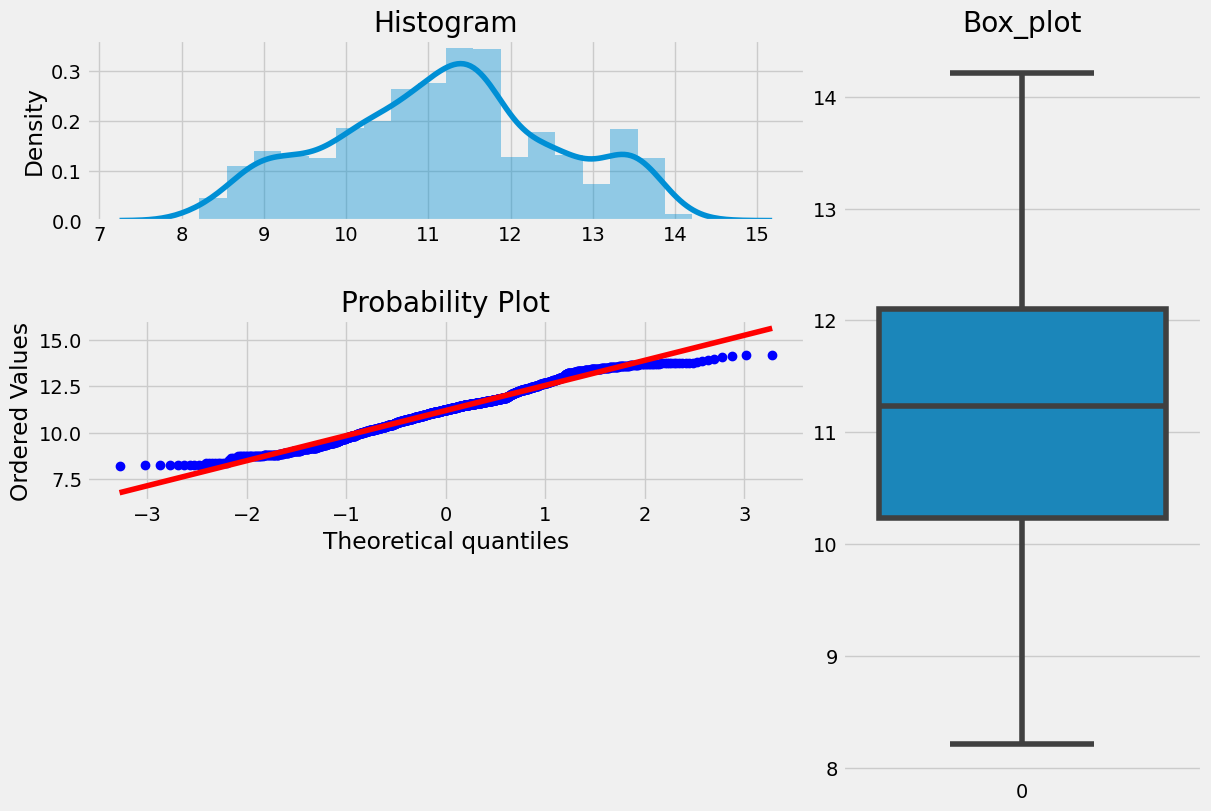

In [25]:
#let's perform the a boxcox transformation
bc_result = boxcox(insur_df.charges)
boxcox_traget = bc_result[0]
lam1 = bc_result[1]
#plot
plotting_3_charts(boxcox_traget)

In [26]:
#let's employ normal test to further check for the skewness. If the p-value is greater than 0.5 then it is skewed
normaltest(boxcox_traget)

NormaltestResult(statistic=53.89147995320849, pvalue=1.9843296302159134e-12)

In [27]:
#let's check the level of skewness
print(f'Skewness: {pd.DataFrame(boxcox_traget).skew()}')

Skewness: 0   -0.008674
dtype: float64


*comment:*

boxcox did a better transformation than log transformation. However, the target column, charges, is not a little bit skewed towards to the left, henec, the negative sign.

>>**Categorical Columns:**

In [28]:
insur_df.select_dtypes('object').columns

Index(['sex', 'smoker', 'region'], dtype='object')

Comment:

We have 3 categorical columns, viz; sex, smoker, region. We shall be visualising and exploring them as follows;

***Sex:***

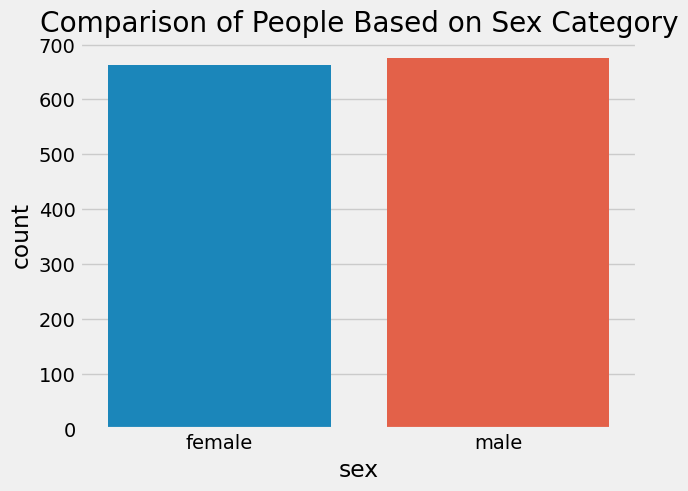

In [29]:
#let's visualize the comaprision of the people in our data based on sex category
sns.countplot(data=insur_df, x = 'sex')
plt.title('Comparison of People Based on Sex Category')
plt.show();

In [30]:
insur_df.sex.value_counts()

male      675
female    662
Name: sex, dtype: int64

Observation:

*   The count of both male and female categories is almost equal, with the males being a little bit higher in number.




***Smoker:***

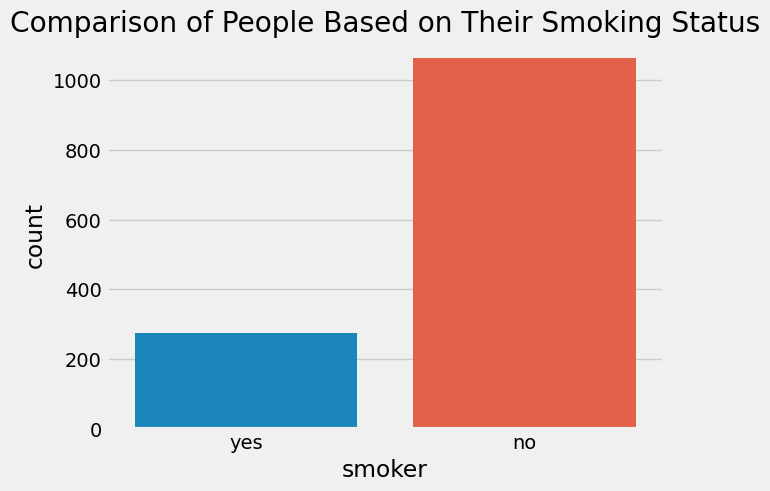

In [31]:
#let's visualize the comparison of based on their smoking status
sns.countplot(data=insur_df, x='smoker')
plt.title('Comparison of People Based on Their Smoking Status')
plt.show();

In [32]:
insur_df.smoker.value_counts()

no     1063
yes     274
Name: smoker, dtype: int64

Observation:

*   Most people in our data are non-smokers.



***Region:***

In [33]:
insur_df.region.unique()

array(['southwest', 'southeast', 'northwest', 'northeast'], dtype=object)

southeast    364
southwest    325
northwest    324
northeast    324
Name: region, dtype: int64


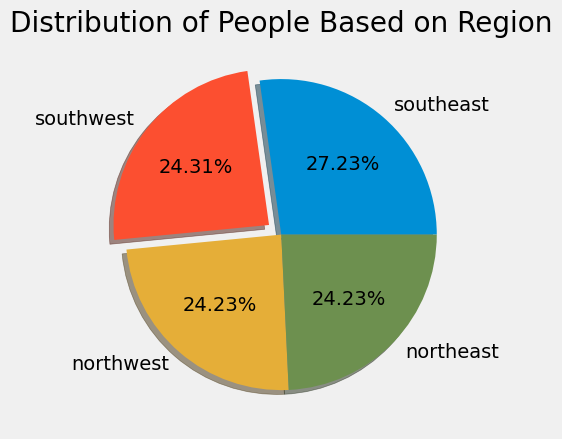

In [34]:
#let's visualize the distribution according to their regions

count_region = insur_df.region.value_counts()
print(count_region)

plt.pie(
    labels = count_region.index,
    x = count_region.values,
    shadow=True,
    autopct = "%.2f%%",
    explode = (0, 0.1,0,0)
)
plt.title('Distribution of People Based on Region')
plt.show();

Observation:

*   The distribution of people based on region is even and almost the same across the various regions, with the southeast region having the most concentration of people.





---



**Bi-Variate & Multi-Variate Analysis:**

---





1.   What is the relationship between cost of insurance charges and gender(sex) of a person, and is this relationship influenced by their smoking status?




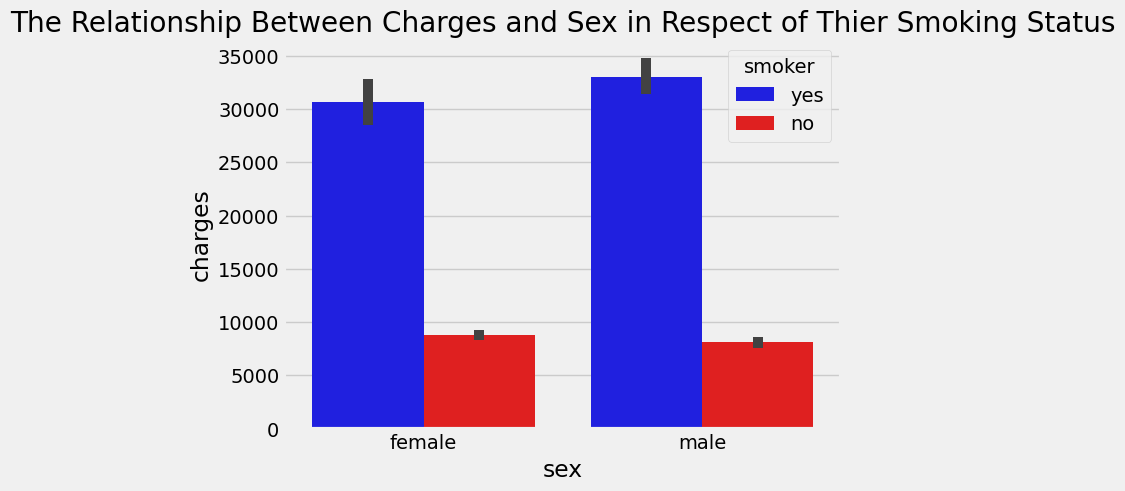

In [35]:
#let's visualize the relationship
hue_colors = {'yes':'blue',
              'no':'red'}
sns.barplot(data=insur_df, x='sex', y='charges', hue='smoker', palette=hue_colors)
plt.title('The Relationship Between Charges and Sex in Respect of Thier Smoking Status')
plt.show();

Observation:

*   There is a higher cost of insurance charges among men than women.
*   There is a greater number of smokers among men than women and this is a great factor contributing to why men incur higher insurance charges than women.





2.   What is the region with the greatest concentration(percentage) of smokers?





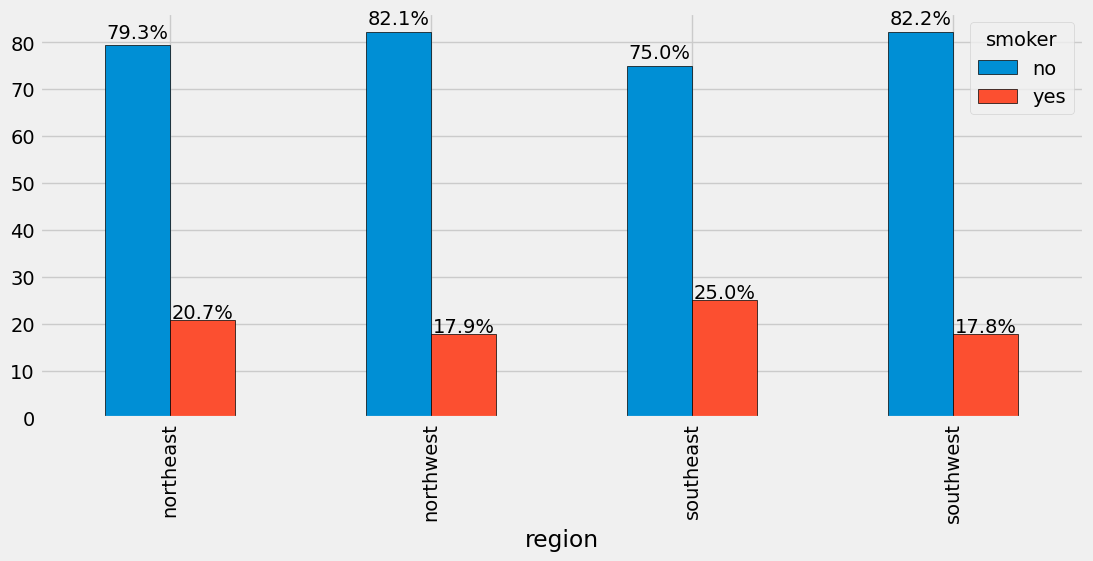

In [36]:
df_rs = (insur_df
         .groupby('region')['smoker']
         .value_counts(normalize=True)
         .mul(100)
         .round(1)
         .unstack()
         )

ax = df_rs.plot(kind='bar', edgecolor='black', figsize=(12,5))

for p in ax.patches:
  width = p.get_width()
  height = p.get_height()
  x,y = p.get_xy()
  ax.annotate(f'{height}%', (x + width/2, y + height * 1.02), ha = 'center')


Observation:


*   The southeast region has the highest concentration(percentage) of smokers
*   The southwest region has the lowest concentration(percentage) of smokers which is very closely followed by the northwest region.
*   Generally, there are more non-smokers than smokers across every of the region.






3.   Does the concentration of smokers in a given region influence the cost of insurance charges across such region?

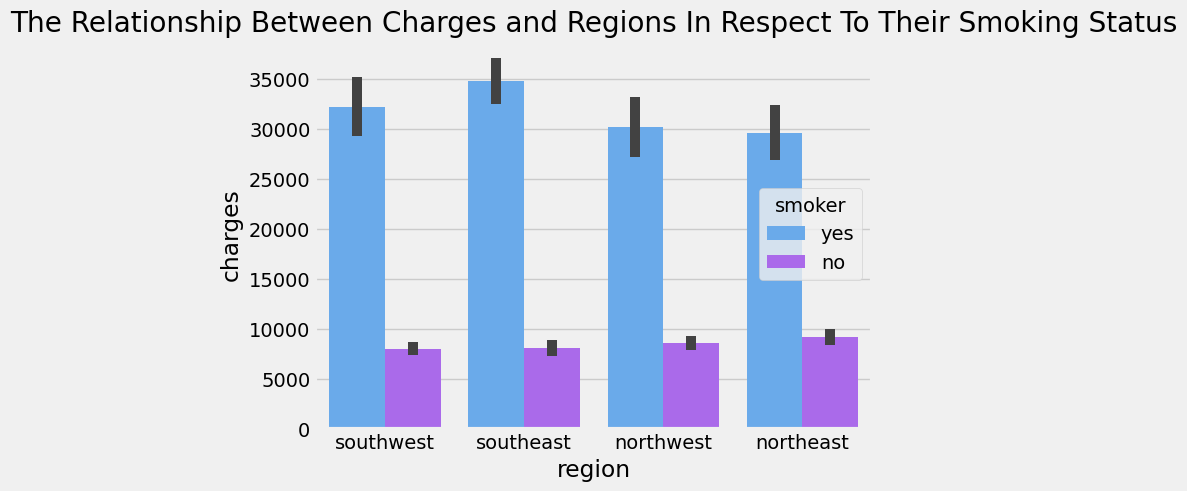

In [37]:
#let's visualize the relationship
sns.barplot(data=insur_df, x='region', y='charges', hue='smoker', palette='cool')
plt.title('The Relationship Between Charges and Regions In Respect To Their Smoking Status')
plt.show();

Observations:

*   Southeast region with the highest concentration of smokers, incurs the highest insurance charges, hence, it is safe to say that smoking is part of the major factors causing it.
*   However, seeing how the southwest region with a lower concentration of smokers compared to the northeast region, which has the second highest concentration of smokers, incurs higher insurance charges, we can sense that other factors beyond just smoking are at play here.





4.   What is the relationship between insurance charges and number of children? Does smoking affect this relationship?

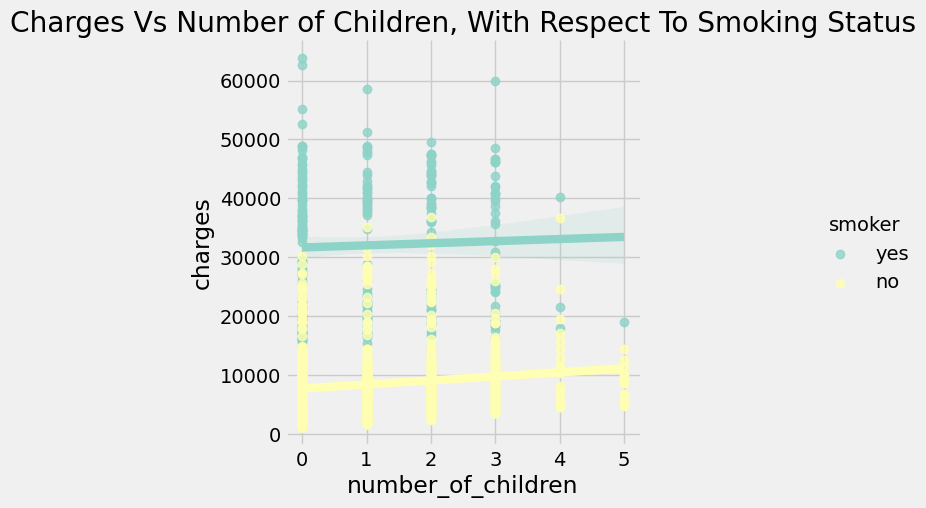

In [38]:
#let's visualize the relationship
sns.lmplot(data=insur_df, x='number_of_children', y='charges', hue='smoker', palette='Set3')
plt.title('Charges Vs Number of Children, With Respect To Smoking Status')
plt.show();


Observation:

*   There are more smokers among those without children than there are, among those with children. Also, people with more children appear to smoke less than those with fewer children.
*   Although insurance charges increase with the increase in the number of children, the presence of smokers tends to overshadow this correlation.






5.   What is the relationship between insurance charges and bmi? Does smoking affect this relationship?




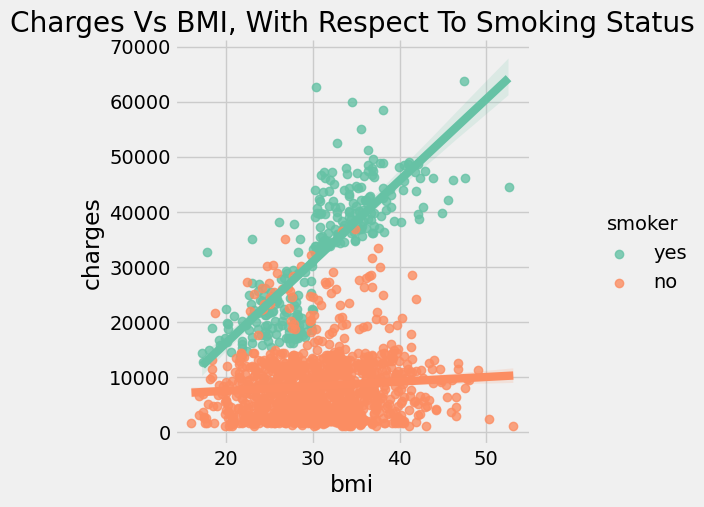

In [39]:
#let's visualize the relationship
sns.lmplot(data=insur_df, x='bmi', y='charges', hue='smoker', palette='Set2')
plt.title('Charges Vs BMI, With Respect To Smoking Status')
plt.show();

Observation:

*   Those with higher BMI tend to pay higher insurance charges
*   There are more smokers among those with higher BMI





6.   What is the relationship between insurance charges and age? Does smoking affect this relationship?




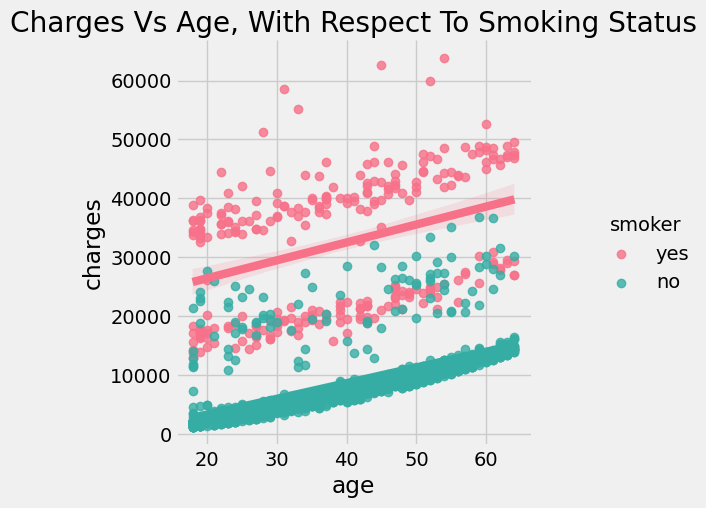

In [40]:
#let's visualize the relationship
sns.lmplot(data=insur_df, x='age', y='charges', hue='smoker', palette='husl')
plt.title('Charges Vs Age, With Respect To Smoking Status')
plt.show();

Observation:

*   Age shows some level of correlation with insurance charges, hence, charges tend to increase with age.
*   Older people tend to smoke more than children, and this could be one of the factors that causes them to incur more insurance charges than children.





---



**Handling Outliers:**

Let's fix the outliers we encountered earlier within the bmi and charges column during the exploratory data analysis as that will enhance the performance of our model.

---



*Let's write a function that checks for outliers:*

In [41]:

def outliers_check(col):
    #calculate the interquartile range
    q25 = col.quantile(0.25)
    q75 = col.quantile(0.75)
    iqr = q75 - q25
    #calculate the high and low threshold beyond which a value will be considered as an outlier
    low_threshold = q25 - (1.5*iqr)
    high_threshold = q75 + (1.5 * iqr)
    #let's identify the outliers
    outliers= [x for x in col if x < low_threshold or x > high_threshold]

    return outliers;



Fixing Outliers in BMI column:



In [42]:
#let's identify the outliers in the bmi column and fix it.
outliers_bmi = outliers_check(insur_df.bmi)
print(f'The Outlers in BMI column:{outliers_bmi}')

The Outlers in BMI column:[49.06, 48.07, 47.52, 47.41, 50.38, 47.6, 52.58, 47.74, 53.13]


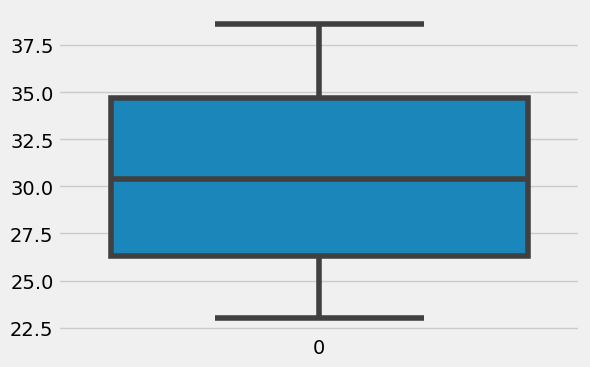

In [43]:
#compute the 10th and 90th percentile
tenth_percentile = np.percentile(insur_df['bmi'], 10)
ninthieth_percentile = np.percentile(insur_df['bmi'], 90)

#let's fix the outliers by flooring the column to 10th percentile and caping it at 90th percentile
insur_df['bmi'] = np.where(insur_df['bmi'] < tenth_percentile, tenth_percentile, insur_df['bmi'])
insur_df['bmi'] = np.where(insur_df['bmi'] > ninthieth_percentile, ninthieth_percentile, insur_df['bmi'])

#let's visualize the column with box_plot and confirm if the outliers have been fixed.
fig = plt.figure(figsize=(6,4))
sns.boxplot(insur_df['bmi'])
plt.show();

Fixing Outliers in Charges Column:

In [44]:
#let's identify the outliers in the bmi column and fix it.
outliers_charges = outliers_check(insur_df['charges'])
print(f'The Outlers in Charges column:{outliers_charges}')

The Outlers in Charges column:[39611.7577, 36837.467, 37701.8768, 38711.0, 35585.576, 51194.55914, 39774.2763, 48173.361, 38709.176, 37742.5757, 47496.49445, 37165.1638, 39836.519, 43578.9394, 47291.055, 47055.5321, 39556.4945, 40720.55105, 36950.2567, 36149.4835, 48824.45, 43753.33705, 37133.8982, 34779.615, 38511.6283, 35160.13457, 47305.305, 44260.7499, 41097.16175, 43921.1837, 36219.40545, 46151.1245, 42856.838, 48549.17835, 47896.79135, 42112.2356, 38746.3551, 42124.5153, 34838.873, 35491.64, 42760.5022, 47928.03, 48517.56315, 41919.097, 36085.219, 38126.2465, 42303.69215, 46889.2612, 46599.1084, 39125.33225, 37079.372, 35147.52848, 48885.13561, 36197.699, 38245.59327, 48675.5177, 63770.42801, 45863.205, 39983.42595, 45702.02235, 58571.07448, 43943.8761, 39241.442, 42969.8527, 40182.246, 34617.84065, 42983.4585, 42560.4304, 40003.33225, 45710.20785, 46200.9851, 46130.5265, 40103.89, 34806.4677, 40273.6455, 44400.4064, 40932.4295, 40419.0191, 36189.1017, 44585.45587, 43254.41795, 3

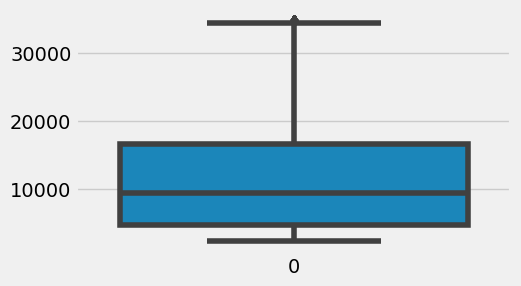

In [45]:
#compute the 10th and 90th percentile
tenth_percentile = np.percentile(insur_df['charges'], 10)
ninthieth_percentile = np.percentile(insur_df['charges'], 90)

#let's fix the outliers by flooring the column to 10th percentile and caping it at 90th percentile
insur_df['charges'] = np.where(insur_df['charges'] < tenth_percentile, tenth_percentile, insur_df['charges'])
insur_df['charges'] = np.where(insur_df['charges'] > ninthieth_percentile, ninthieth_percentile, insur_df['charges'])

#let's visualize the column with box_plot and confirm if the outliers have been fixed.
fig = plt.figure(figsize=(5,3))
sns.boxplot(insur_df['charges'])
plt.show();

Comment:

We have fixed the outliers in both columns, and we can confirm that through our box_plot visualization.

****

**Encoding:**

---



In [46]:
#let's encode the categorical columns into numbers
cat_cols = insur_df.select_dtypes('object').columns
print(cat_cols)

#instantiate
encoder = LabelEncoder()
#encode each of the cat_cols
for col in cat_cols:
  insur_df[col] = encoder.fit_transform(insur_df[col])

print(insur_df.head())
print(insur_df.dtypes)

Index(['sex', 'smoker', 'region'], dtype='object')
   age  sex    bmi  number_of_children  smoker  region      charges
0   19    0  27.90                   0       1       3  16884.92400
1   18    1  33.77                   1       0       2   2358.52481
2   28    1  33.00                   3       0       2   4449.46200
3   33    1  22.99                   0       0       1  21984.47061
4   32    1  28.88                   0       0       1   3866.85520
age                     int64
sex                     int64
bmi                   float64
number_of_children      int64
smoker                  int64
region                  int64
charges               float64
dtype: object


**Let's Visualize the correlation across the columns:**

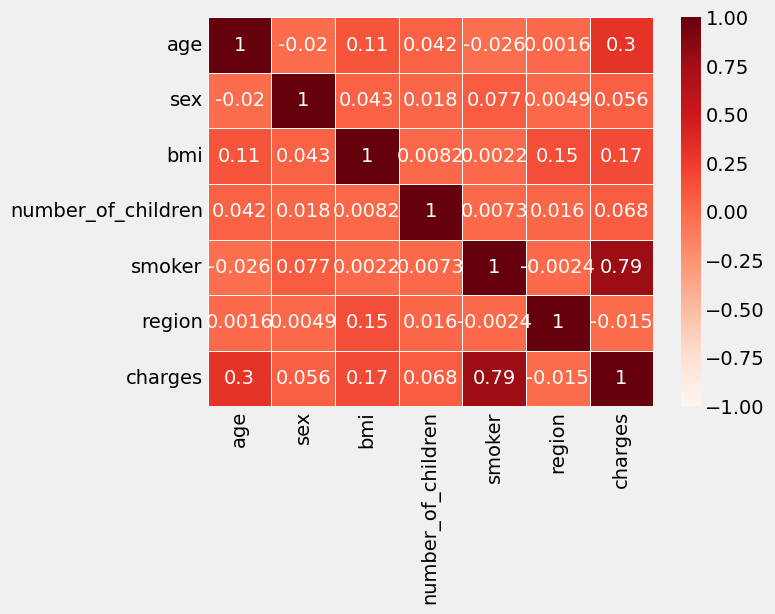

In [47]:
correlation = insur_df.corr()
sns.heatmap(correlation, cmap='Reds', annot=True, vmin=-1, vmax=1, linewidths=.5)
plt.show;

Observation:

*   Smoking has a very strong correlation with insurance charges.
*   Age shows some level of correlation with insurance, although the correlation is not pronounced enough.





---



**Modeling:**

---



In [48]:
#let's split our dataframe into feature and target variable
target = 'charges'
y = insur_df[target]
X = insur_df.drop(target, axis=1)

In [49]:
print(y)

0       16884.92400
1        2358.52481
2        4449.46200
3       21984.47061
4        3866.85520
           ...     
1333    10600.54830
1334     2358.52481
1335     2358.52481
1336     2358.52481
1337    29141.36030
Name: charges, Length: 1337, dtype: float64


In [50]:
print(X.head())

   age  sex    bmi  number_of_children  smoker  region
0   19    0  27.90                   0       1       3
1   18    1  33.77                   1       0       2
2   28    1  33.00                   3       0       2
3   33    1  22.99                   0       0       1
4   32    1  28.88                   0       0       1




---





*   *Baseline Model:*

Let's build our baseline or naive model first. With it we can be able to evaluate the performance of our other models.

---






In [51]:
y_train_base = y.copy()
y_mean = y_train_base.mean()
y_pred_baseline = [y_mean] * len(y_train_base)
baseline_mae = mean_absolute_error(y_train_base, y_pred_baseline)
print(f'Mean Insurance Charges: {round(y_mean,3)}')
print(f'Mean Absolute Error of Baseline Model: {round(baseline_mae,3)}')

Mean Insurance Charges: 12578.608
Mean Absolute Error of Baseline Model: 8040.152


Comment:


*   What this implies is that if we predicted an insurance charge of about 12578 dollars(the mean insurance charges), we will be off by $8040. Hence, for any of our models to be considered good, it will have to beat the mean_absolute_error of this naive model by predicting with a mean_absolute_error smaller than what we got from the naive model.





---



*let's split our target and feature variables into train and test set:*

In [52]:
#split the data into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)



---



1. Linear Regression:



---



In [53]:
#let's make a pipeline for our model
pipe = make_pipeline(StandardScaler(),
                         LinearRegression())
#fit the model
linear_reg = pipe.fit(X_train, y_train)
y_pred_reg = linear_reg.predict(X_test)



In [54]:
#let's evaluate our model
print(f'Mean Absolute Error: {round(mean_absolute_error(y_test,y_pred_reg),3)}')
print(f'Mean Squared Error: {round(mean_squared_error(y_test, y_pred_reg),3)}')
print(f'R2_Score: {round(r2_score(y_test, y_pred_reg),3)}')

Mean Absolute Error: 3178.063
Mean Squared Error: 24126130.408
R2_Score: 0.779


In [55]:
#let's compare our actual charges against the predicted charges by our Linear Regression Model
compare = pd.DataFrame({
    'Actual Charges': y_test.values.round(2),
    'Predicted Charges': np.round(y_pred_reg,2)
})

compare.head(10)

,Actual Charges,Predicted Charges
0,8688.86,8302.54
1,5708.87,5719.28
2,11436.74,13615.92
3,34832.74,28226.05
4,4463.21,9001.01
5,9304.70,12774.13
6,34832.74,26981.89
7,2358.52,2188.46
8,7345.73,10629.62
9,10264.44,10906.20


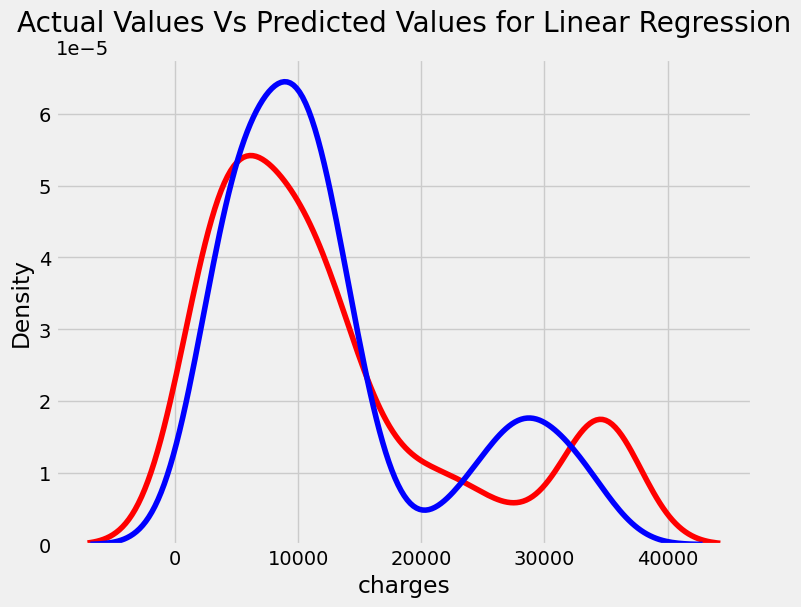

In [56]:
#let's visualize how close our predictions are to the actual values
fig = plt.figure(figsize=(8,6))
ax = sns.distplot(y_test, color='r', label='Actual Values', hist=False)
sns.distplot(y_pred_reg, color='b', label='Predicted Values', hist=False, ax=ax)
plt.title('Actual Values Vs Predicted Values for Linear Regression')
plt.show();

Comment:


*   The graph visualizes how close the values predicted by the model are to the actual values.
*   The red-coloured line represents the actual values while the blue-coloured line represents the predicted values.
*   The more closely both lines overlap each other, the more accurate the prediction and vice versa.

---



*Side Note:*

I did not bother transforming the y_train with boxcox or log because the model performed better with a y_train that is not transformed by this measures.



---





2.   Polynomial Linear Regression:

---






In [57]:
X_p = X.copy()
y_p = y.copy()

In [58]:
#create a polynomial feature
pf = PolynomialFeatures(degree=2, include_bias=False)
X_pf = pf.fit_transform(X_p)

In [59]:
#let's split our target and feature variables into train and test set
X_train, X_test, y_train, y_test = train_test_split(X_pf, y_p, test_size=0.3, random_state=42)

In [60]:
#fit StandardScaler on X_train
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)

In [61]:
#instantiate, fit and predict with the model
lr = LinearRegression()
lr.fit(X_train_s, y_train)
#standardize the X_test before predicting with it
X_test_s = scaler.transform(X_test)
#make the predictions
y_pred_pr = lr.predict(X_test_s)

In [62]:
#Evaluate the model
print(f"Mean Absolute Error: {round(mean_absolute_error(y_test, y_pred_pr),3)}")
print(f"Mean Squared Error: {round(mean_squared_error(y_test,y_pred_pr),3)}")
print(f"R2_Score: {round(r2_score(y_test,y_pred_pr),3)}")

Mean Absolute Error: 2623.232
Mean Squared Error: 19027095.412
R2_Score: 0.825


In [63]:
#let's compare our actual charges against the predicted charges by our Polynomial Linear Regression Model
compare = pd.DataFrame({
    'Actual Charges': y_test.values.round(2),
    'Predicted Charges': np.round(y_pred_pr,2)
})

compare.head(10)

,Actual Charges,Predicted Charges
0,8688.86,8911.26
1,5708.87,5932.75
2,11436.74,13518.79
3,34832.74,32438.98
4,4463.21,6334.25
5,9304.70,10767.36
6,34832.74,34924.99
7,2358.52,3239.24
8,7345.73,8512.50
9,10264.44,11873.59


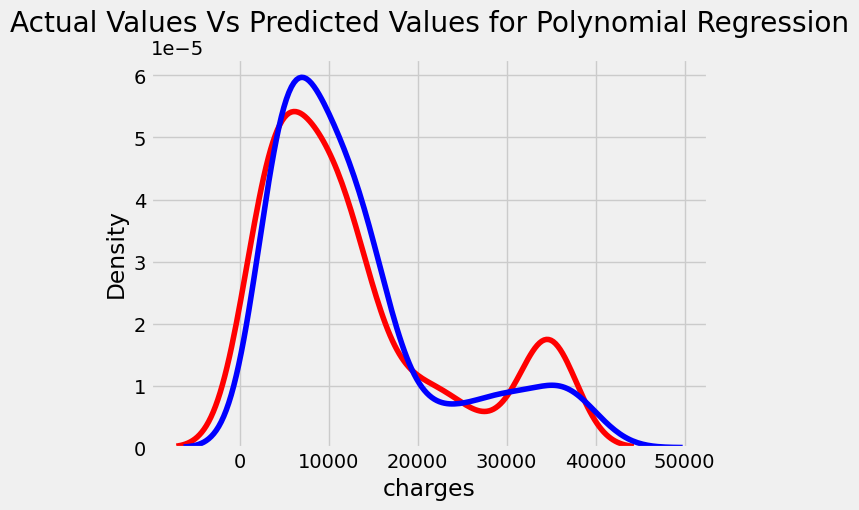

In [64]:
#let's visualize how close our predictions are to the actual values
ax = sns.distplot(y_test, color='r', label='Actual Values', hist=False)
sns.distplot(y_pred_pr, color='b', label='Predicted Values', hist=False, ax=ax)
plt.title('Actual Values Vs Predicted Values for Polynomial Regression')
plt.show();

Comment:

*   The graph visualizes how close the values predicted by the model are to the actual values.
*   The red-coloured line represents the actual values while the blue-coloured line represents the predicted values.
*   The more closely both lines overlap each other, the more accurate the prediction and vice versa.


---




*Side Note:*

I did not bother transforming the y_train with boxcox or log because the model performed better with a y_train that is not transformed by this measures just like I witnessed during the linear regression.



---



3. Ridge Regression:

In [65]:
#create estimators
estimators = Pipeline([
    ('polynomial_features', PolynomialFeatures()),
    ('scaler', StandardScaler()),
    ('ridge_regression', Ridge(max_iter=100000))])

In [66]:
#create hyperparameters for tunning
params_ridge = {
    'polynomial_features__degree': [1,2,3],
    'ridge_regression__alpha': np.geomspace(0.1,2,20)
}

In [67]:
#create a KFold object
kf = KFold(shuffle=True, random_state=42, n_splits=3)

In [68]:
#let's perform the hyperparameter tuning with GridSearchCV and predict with it.
grid_ridge = GridSearchCV(estimators, params_ridge, cv=kf)
#fit the model
grid_ridge.fit(X_train, y_train)
#print the best parameters
grid_ridge.best_params_
#print the best parameters
grid_ridge.best_params_

{'polynomial_features__degree': 1,
 'ridge_regression__alpha': 1.7082629933755134}

In [69]:
#fit and predict with the fine-tunned model
ridge_reg = Pipeline([
    ('polynomial_features', PolynomialFeatures(degree=1)),
    ('scaler', StandardScaler()),
    ('ridge_regression', Ridge(max_iter=100000, alpha=1.7082629933755134))])

ridge_reg.fit(X_train, y_train)
y_pred_ridge = ridge_reg.predict(X_test)

In [70]:
#let's evaluate our model
print(f'Mean Absolute Error: {round(mean_absolute_error(y_test, y_pred_ridge),3)}')
print(f'Mean Squared Error: {round(mean_squared_error(y_test, y_pred_ridge),3)}')
print(f'R2_Score: {round(r2_score(y_test, y_pred_ridge),3)}')

Mean Absolute Error: 2617.475
Mean Squared Error: 18984516.466
R2_Score: 0.826


In [71]:
#let's compare our actual charges against the predicted charges by our Ridge Regression Model
compare = pd.DataFrame({
    'Actual Charges': y_test.values.round(2),
    'Predicted Charges': np.round(y_pred_ridge,2)
})

compare.head(10)

,Actual Charges,Predicted Charges
0,8688.86,9020.00
1,5708.87,5843.69
2,11436.74,13729.09
3,34832.74,32073.51
4,4463.21,6608.54
5,9304.70,10987.08
6,34832.74,34185.27
7,2358.52,3226.11
8,7345.73,8667.82
9,10264.44,11775.47


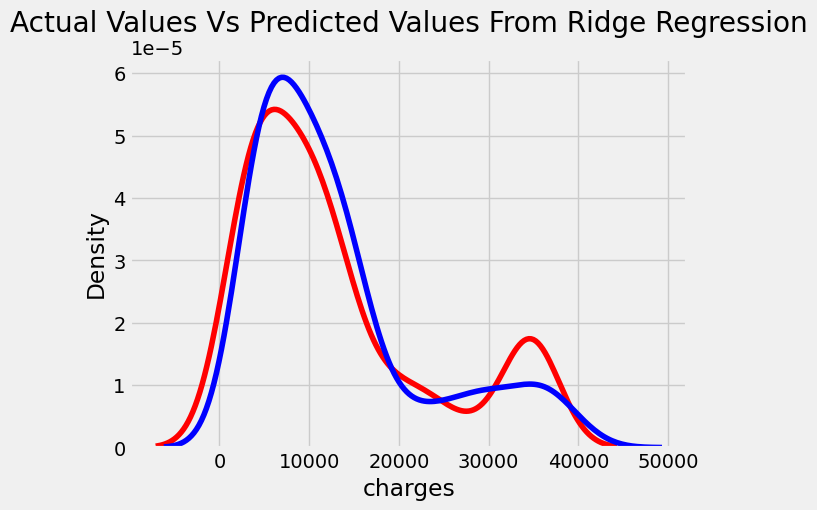

In [72]:
#let's visualize how close our ridge model predictions are to the actual values
ax = sns.distplot(y_test, color='r', label='Actual Values', hist=False)
sns.distplot(y_pred_ridge, color='b', label='Predicted Values', hist=False, ax=ax)
plt.title('Actual Values Vs Predicted Values From Ridge Regression')
plt.show();



---



4. Lasso Regression:



---



In [73]:
#create estimators
estimators = Pipeline([
    ('scaler', StandardScaler()),
    ('model', Lasso(max_iter=100000))
])


In [74]:
#create hyperparameters
params_lasso = {
    'model__alpha':np.geomspace(0.1, 2, 20)
}

In [75]:
#hperparameter tuning
grid = GridSearchCV(estimators, params_lasso, cv=kf)
#fit the model
grid.fit(X_train, y_train)
y_pred_lasso = grid.predict(X_test)

In [76]:
print(grid.best_params_)
print(grid.best_estimator_)

{'model__alpha': 2.0}
Pipeline(steps=[('scaler', StandardScaler()),
                ('model', Lasso(alpha=2.0, max_iter=100000))])


In [77]:
#let's evaluate our model
print(f'Mean Absolute Error: {round(mean_absolute_error(y_test, y_pred_lasso),3)}')
print(f'Mean Squared Error: {round(mean_squared_error(y_test, y_pred_lasso),3)}')
print(f'R2_Score: {round(r2_score(y_test, y_pred_lasso),3)}')

Mean Absolute Error: 2622.476
Mean Squared Error: 19012015.216
R2_Score: 0.826


In [78]:
#let's compare our actual charges against the predicted charges by our Lasso Regression Model
compare = pd.DataFrame({
    'Actual Charges': y_test.values.round(2),
    'Predicted Charges': np.round(y_pred_lasso,2)
})

compare.head(10)

,Actual Charges,Predicted Charges
0,8688.86,9081.86
1,5708.87,5922.45
2,11436.74,13591.01
3,34832.74,32383.00
4,4463.21,6414.06
5,9304.70,10823.70
6,34832.74,34823.66
7,2358.52,3232.34
8,7345.73,8579.84
9,10264.44,11854.98


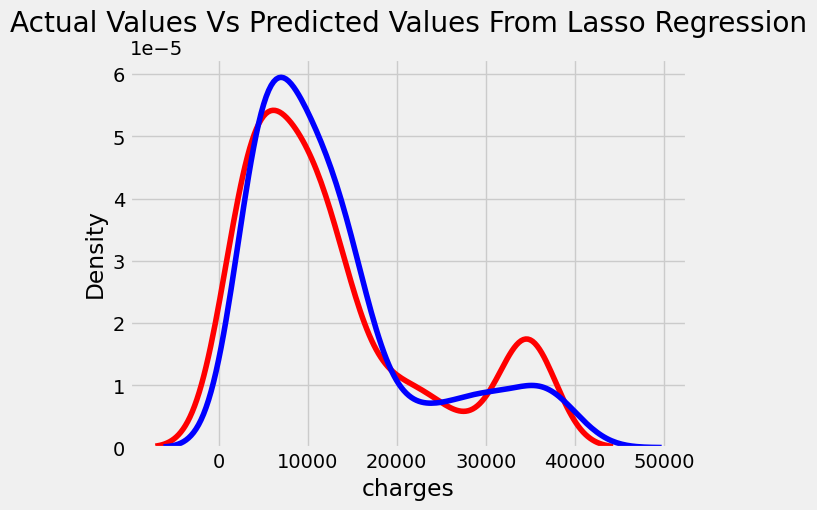

In [79]:
#let's visualize how close our lasso model predictions are to the actual values
ax = sns.distplot(y_test, color='r', label='Actual Values', hist=False)
sns.distplot(y_pred_lasso, color='b', label='Predicted Values', hist=False, ax=ax)
plt.title('Actual Values Vs Predicted Values From Lasso Regression')
plt.show();

Comment:

*   The graph visualizes how close the values predicted by the model are to the actual values.
*   The red-coloured line represents the actual values while the blue-coloured line represents the predicted values.
*   The more closely both lines overlap each other, the more accurate the prediction and vice versa.



---



5. Random Forest Regressor:

---



In [80]:
#instantiate Random Forest Model
rf = RandomForestRegressor()

#define a grid of hyperparameters
params_rf = {
    'random_state':[1, 42, 72018],
    'n_estimators':[50,200, 300, 400, 500],
    'max_depth':[None,4,5,6,8],
    'min_samples_leaf':[0.1, 0.2],
    'max_features':['log2', 'sqrt']
}

#instantiate model
grid_rf = GridSearchCV(
    estimator=rf,
    param_grid=params_rf,
    cv=kf,
    scoring='neg_mean_squared_error',
)


In [81]:
#fit model and predict
grid_rf.fit(X_train, y_train)
y_pred_rf = grid_rf.predict(X_test)

In [82]:
print(grid_rf.best_estimator_)

RandomForestRegressor(max_features='sqrt', min_samples_leaf=0.1,
                      n_estimators=50, random_state=42)


In [83]:
#let's evaluate our model
print(f'Mean Absolute Error: {round(mean_absolute_error(y_test, y_pred_rf),3)}')
print(f'Mean Squared Error: {round(mean_squared_error(y_test, y_pred_rf),3)}')
print(f'R2_Score: {round(r2_score(y_test, y_pred_rf),3)}')

Mean Absolute Error: 4414.876
Mean Squared Error: 35091846.061
R2_Score: 0.678


In [84]:
#let's compare our actual charges against the predicted charges by our Random Forest Regressor
compare = pd.DataFrame({
    'Actual Charges': y_test.values.round(2),
    'Predicted Charges': np.round(y_pred_rf,2)
})

compare.head(10)

,Actual Charges,Predicted Charges
0,8688.86,10750.19
1,5708.87,7987.53
2,11436.74,12841.60
3,34832.74,23341.35
4,4463.21,8933.59
5,9304.70,13124.88
6,34832.74,22692.46
7,2358.52,5850.13
8,7345.73,10853.40
9,10264.44,12454.80


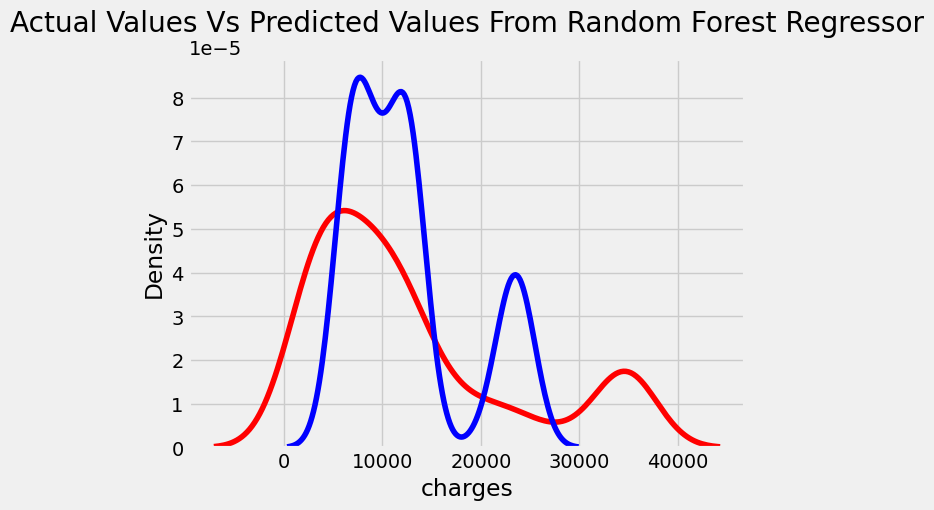

In [85]:
#let's visualize how close our lasso model predictions are to the actual values
ax = sns.distplot(y_test, color='r', label='Actual Values', hist=False)
sns.distplot(y_pred_rf, color='b', label='Predicted Values', hist=False, ax=ax)
plt.title('Actual Values Vs Predicted Values From Random Forest Regressor')
plt.show();

Comment:

*   The graph visualizes how close the values predicted by the model are to the actual values.
*   The red-coloured line represents the actual values while the blue-coloured line represents the predicted values.
*   The more closely both lines overlap each other, the more accurate the prediction and vice versa.



---



**Comparing Our Models:**

---



In [86]:
algorithms = {
    'Model':['Linear Regression', 'Polynomial-Linear Regression', 'Ridge Regression',
             'Lasso Regression', 'Random Forest Regressor'],
    'Mean Absolute Error':[round(mean_absolute_error(y_test, y_pred_reg),3),
                           round(mean_absolute_error(y_test, y_pred_pr),3),
                           round(mean_absolute_error(y_test, y_pred_ridge),3),
                           round(mean_absolute_error(y_test, y_pred_lasso),3),
                           round(mean_absolute_error(y_test, y_pred_rf),3)
                           ],
    'Mean Squared Error': [round(mean_squared_error(y_test, y_pred_reg),3),
                           round(mean_squared_error(y_test, y_pred_pr),3),
                           round(mean_squared_error(y_test, y_pred_ridge),3),
                           round(mean_squared_error(y_test, y_pred_lasso),3),
                           round(mean_squared_error(y_test, y_pred_rf),3)
                           ],
    'R2_Score':[round(r2_score(y_test, y_pred_reg),3),
                round(r2_score(y_test, y_pred_pr),3),
                round(r2_score(y_test, y_pred_ridge),3),
                round(r2_score(y_test, y_pred_lasso),3),
                round(r2_score(y_test, y_pred_rf),3)
                ]
}

df = pd.DataFrame(algorithms)
df

,Model,Mean Absolute Error,Mean Squared Error,R2_Score
0,Linear Regression,3178.063,2.412613e+07,0.779
1,Polynomial-Linear Regression,2623.232,1.902710e+07,0.825
2,Ridge Regression,2617.475,1.898452e+07,0.826
3,Lasso Regression,2622.476,1.901202e+07,0.826
4,Random Forest Regressor,4414.876,3.509185e+07,0.678


**CONCLUSION:**

*   Ridge Regression is the best-performing model, and this is captured across the three metrics we employed in evaluating all the models.
*   Random Forest Regressor is the least-performing model. However, all the five(5) models we employed performed way better than our baseline(naive) model and that's a good thing😊😋.
*  Smoking has the strongest correlation with insurance charges among all the features.

# The End!!!😊😋❤️

---





---

